<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# KNN and Support Vector Machines

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from matplotlib.colors import ListedColormap
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

## Setup

We are going to use a dataset from the University of Wisconsin which contains features of the cell nuclei present in biopsies of breast masses.  The target to predict is whether the mass is malignant or benign.  Description of the dataset can be found here: https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)

In [2]:
from sklearn.datasets import load_breast_cancer
data=load_breast_cancer(as_frame=True)
X,y=data.data,data.target
# Since the default in the file is 0=malignant 1=benign we want to reverse these
y=(y==0).astype(int)
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# Let's set aside a test set and use the remainder for training and cross-validation
X_train,X_test,y_train,y_test = train_test_split(X, y, random_state=0,test_size=0.2)

# Let's scale the inputs to help it converge more easily
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X_train.columns)

# Let's create a model using just two features so we can visualize it
X_train_2feats = X_train_scaled[['worst concave points','worst area']]
X_test_2feats = X_test_scaled[['worst concave points','worst area']]

In [4]:
def plot_decision_boundaries(X,y,model):
    """
    Plots the 2D decision boundary of a classification model
    Parameters:
    X (pandas dataframe): input features
    y (pandas series): target values
    model: trained scikit-learn model object
    """
    markers = ['^','s','v','o','x']
    colors = ['yellow','green','purple','blue','orange']
    cmap = ListedColormap(colors[:len(np.unique(y))])
    
    for i,k in enumerate(np.unique(y)):
        plt.scatter(X.loc[y.values==k].iloc[:,0],X.loc[y.values==k].iloc[:,1],
                    c=colors[i],marker=markers[i],label=k,edgecolor='black')

    xgrid = np.arange(X.iloc[:,0].min(),X.iloc[:,0].max(),
                      (X.iloc[:,0].max()-X.iloc[:,0].min())/500)
    ygrid = np.arange(X.iloc[:,1].min(),X.iloc[:,1].max(),
                      (X.iloc[:,1].max()-X.iloc[:,1].min())/500)
    xx,yy = np.meshgrid(xgrid,ygrid)
    
    mesh_preds = model.predict(np.c_[xx.ravel(),yy.ravel()])
    mesh_preds = mesh_preds.reshape(xx.shape)
    plt.contourf(xx,yy,mesh_preds,alpha=0.2,cmap=cmap)
    plt.legend()
    return

## PART 1: KNN
In this part we will use cross-validation with 5 folds and accuracy as the evaluation metric to find the optimal value for `n_neighbors`.  The search space we will evaluate for n_neighbors is [1,3,5,10].  After you find the optimal `n_neighbors`, plot the decision boundaries of your model and calculate the accuracy on the test set.

Optimal n_neighbors: 5
Accuracy: 0.956140350877193


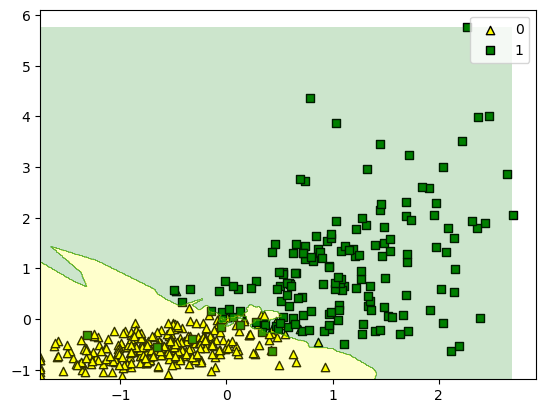

In [14]:
### BEGIN SOLUTION ###
kf = KFold(n_splits=5)
best_acc = 0
best_model = None
optimal_n_neighbors = None

for n_neighbors in [1,2,5,10]:
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    accs = []
    for train_indexes,test_indexes in kf.split(X_train_2feats):
        X_train_fold,X_test_fold = X_train_2feats.iloc[train_indexes],X_train_2feats.iloc[test_indexes]
        y_train_fold,y_test_fold = y_train.iloc[train_indexes],y_train.iloc[test_indexes]
        model.fit(X_train_fold,y_train_fold)
        accs.append(accuracy_score(y_test_fold,model.predict(X_test_fold)))

    if np.mean(accs) > best_acc:
        best_acc = np.mean(accs)
        optimal_n_neighbors = n_neighbors
        best_model = model

plot_decision_boundaries(X_train_2feats,y_train,best_model)

test_acc = accuracy_score(y_test,best_model.predict(X_test_2feats))

print("Optimal n_neighbors:",optimal_n_neighbors)
print("Accuracy:",test_acc)

### END SOLUTION ###

## PART 2: Support Vector Classifiers
### 2.1
We will now try a SVC on our two-feature simplified dataset.  In the cells below, create two different SVC models:  
- SVC with a linear kernel. 
- SVC with a RBF kernel. 

For each model, keep the value of C fixed at 1.  Use k-folds cross-validation with k=10 to compare the performance of the two models.  Also, display the decision boundary for each model. Then, select the kernel which gives you better cross-validation performance as your final model and calculate the accuracy on the test set.

Linear  kernel accuracy:  0.9495652173913044
RBF  kernel accuracy:  0.9429951690821257
Best performance kernel is  Linear
Test accuracy: 0.9473684210526315


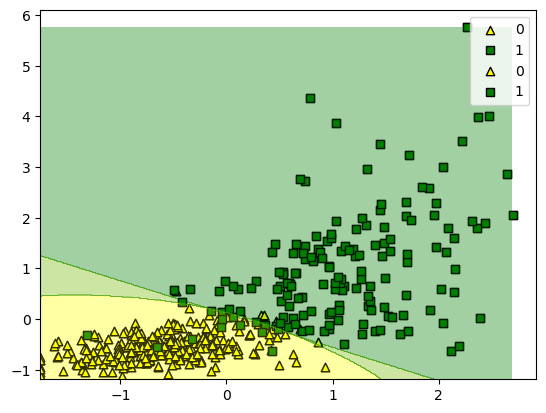

In [21]:
### BEGIN SOLUTION ###
kf = KFold(n_splits=10)

models = [SVC(kernel='linear', C=1), SVC(kernel='rbf', C=1)]
model_names = ['Linear', 'RBF']
model_accs = []

for index, model in enumerate(models):
    accs = []
    for train_indexes, test_indexes in kf.split(X_train_2feats):
        X_train_fold, X_test_fold = X_train_2feats.iloc[train_indexes], X_train_2feats.iloc[test_indexes]
        y_train_fold, y_test_fold = y_train.iloc[train_indexes], y_train.iloc[test_indexes]
        model.fit(X_train_fold, y_train_fold)
        accs.append(accuracy_score(y_test_fold, model.predict(X_test_fold)))

    mean_acc = np.mean(accs)
    print(model_names[index], " kernel accuracy: ", mean_acc)
    model_accs.append(mean_acc)
    
    plot_decision_boundaries(X_train_2feats, y_train, model)

best_model_index = np.argmax(model_accs)
print("Best performance kernel is ", model_names[best_model_index])

test_acc = accuracy_score(y_test, models[best_model_index].predict(X_test_2feats))
print("Test accuracy:", test_acc)

### END SOLUTION ###

### 2.2
Now, let's try a polynomial kernel.  Vary the polynomial degree from 2 through 4 and create and train a SVC model with a polynomial kernel of each degree.  Leave the value of C constant at 1.  For each model, display the resulting decision boundary and calculate the cross-validation accuracy using k=10.  Visually compare the decision boundaries and their performance in classifying the data.  Then, determine which degree has the best performance in classifying the data and calculate the performance of a SVC model with that degree of polynomial kernel on the test set.

Degree:  2
Accuracy: 0.7864734299516908
Degree:  3
Accuracy: 0.9032850241545894
Degree:  4
Accuracy: 0.8128985507246377
Optimal degree for polynomial kernel is:  3
Test accuracy: 0.8771929824561403


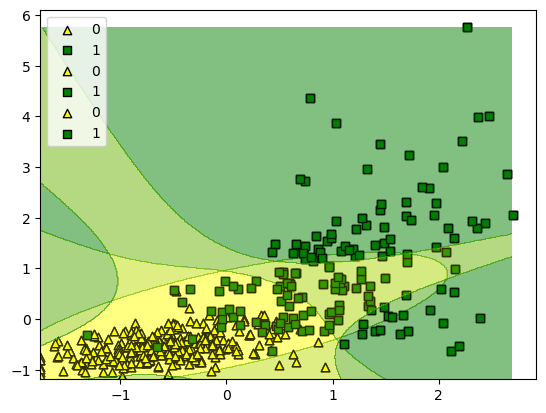

In [17]:
### BEGIN SOLUTION ###

best_model = None
best_acc = 0
best_degree = None

for deg in range(2,5,1):
    print("Degree: ",deg)
    pol_model = SVC(kernel='poly',degree=deg)
    accs = []
    kf = KFold(n_splits=10)
    for train_indexes,test_indexes in kf.split(X_train_2feats):
        X_train_fold,X_test_fold = X_train_2feats.iloc[train_indexes],X_train_2feats.iloc[test_indexes]
        y_train_fold,y_test_fold = y_train.iloc[train_indexes],y_train.iloc[test_indexes]
        pol_model.fit(X_train_fold,y_train_fold)
        accs.append(accuracy_score(y_test_fold,pol_model.predict(X_test_fold)))

    mean_acc = np.mean(accs)
    print("Accuracy:", mean_acc)
    plot_decision_boundaries(X_train_2feats,y_train,pol_model)

    if mean_acc > best_acc:
        best_acc = mean_acc
        best_model = pol_model
        best_degree = deg

print("Optimal degree for polynomial kernel is: ", best_degree)
test_acc = accuracy_score(y_test,best_model.predict(X_test_2feats))
print("Test accuracy:", test_acc)

### END SOLUTION ###